# Kalman Filter: Helical track

Extract 5 parameters ( typically longitudinal momentum, transverse momentum and and vertex position in a particle-physics context ) from a list of points ("hits") in 3-dimensional space.

In [1]:
%pylab --no-import-all
#  mainly equivalent to 
#import  numpy as np
#import matplotlib.pyplot as plt
# allow python3 syntax
from __future__ import division, print_function, absolute_import
# 3d projections in plot
from mpl_toolkits.mplot3d import Axes3D
# local file with often used functions
import kalman as k

In [ ]:
# show contents of local file 
# functions can be called through 'import kalman'
# %load kalman.py

def kalman_predict( A, # transition matrix 
            r, # measurement error matrix
            H, # transformation matrix from state vector to measurement
            p, # initial variance on prediction
            xkal, # estimated state vector
            xpredict, # predicted state vector
            xmeas): # measurements
    for i in range(1, xkal.shape[1]): # for each measurement do 
        # prediction: recursive formula
        xpredict[:, i] = np.dot(A, xkal[:, i - 1])
        # predict covariance  
        p = A*p*A.T
        # construct kalman gain matrix according to prediction equations
        # higher gain leads to higher influence of measurement,
        # lower gain to higher influence of predicion
        K = np.dot(p*H.T, np.linalg.inv(H*p*H.T + r))
        # construct estimate from prediction and gain 
        xkal[:, i] = xpredict[:, i] + K*(xmeas[:, i] - H*xpredict[:, i])
        # update covariance with gain
        p = (np.identity(K.shape[0]) - K * H) * p
    return xkal, xpredict

def plot_results(xkal, xpredict, xmeas, xtrue):
    fig1 = plt.figure()
    ax1 = plt.axes()
    plt.plot(xtrue, 'b-', label = 'True')
    plt.plot(xmeas[0].T, 'rx', label = 'Measurement')
    plt.plot(xpredict[0].T, 'g.',  label = 'Prediction')
    plt.plot(xkal[0].T, 'ko', label = 'Kalman')
    plt.xlabel('Iteration')
    plt.ylabel('X')

    fig2 = plt.figure()
    ax2 = plt.axes()
    #plt.axhline(v)
    plt.axhline(np.mean(xmeas[1]))
    plt.plot(xpredict[1].T, 'g.',  label = 'Prediction')
    plt.plot(xmeas[1].T, 'rx', label = 'Measurement')
    plt.plot(xkal[1].T, 'ko', label = 'Kalman')
    plt.xlabel('Iteration')
    plt.ylabel('Velocity')
    return [[fig1, fig2], [ax1, ax2]]


## Global parametrization
For simplicity take only radius of circle and some transposition of the origin
along x-axis.

In [4]:

dt = 0.2
# final time for track
T = 2 * np.pi
# number of measurements
N = int(T / dt)
# position, velocity and acceleration
state_vec_dim = 5
# parabola with some curvature g 
# errors
sigma_pos = 1e-1
# initial track parameters
true_params = (1, 1, 1, 1, 1)
x0, y0, z0, cotTheta, q_pT = true_params 
# shorthand for array of times
_t = np.linspace(0, T, N)
# centered helix
xtrue  = np.vstack(( x0 +  q_pT  * np.cos(_t), 
                    y0 +  q_pT * np.sin(_t), 
                    z0 + cotTheta * _t))
print(xtrue)
 


In [5]:
#"""
#'''
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
print(xtrue[0][0].squeeze().shape)
ax.scatter(*xtrue[:,:], marker='o')
plt.draw()
plt.show()
plt.plot(xtrue[0].T, xtrue[1].T)
plt.title('true track')
plt.xlabel('x')
plt.ylabel('y')
print(xtrue.shape)

In [6]:
# add noise
measurement_noise = np.random.normal(loc=0, scale=sigma_pos, 
                                    size=xtrue.shape)
print(measurement_noise)
xmeas = xtrue + measurement_noise
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plt.plot(xmeas[0].T, xmeas[1].T)
plt.title('noisy measurements of track')
plt.xlabel('x')
plt.ylabel('y')
#fig = plt.figure(figsize=(6,6))
#ax = fig.add_subplot(111, projection='3d')
print(xtrue[0][0].squeeze().shape)
ax.scatter(*xmeas[:,:], marker='o')
plt.draw()

[[  1.10000000e+00   1.16704371e+00   1.23450505e+00   1.09848232e+00   1.10813186e+00   9.91905258e-01   9.94136293e-01   9.74902443e-01
    9.84767620e-01   9.87981040e-01   9.93273647e-01   9.95188453e-01   1.00105905e+00   1.00039590e+00   1.00377991e+00   9.91004804e-01
    1.00527444e+00   1.00067667e+00   9.98620555e-01   1.00224422e+00   1.00253386e+00   1.00646350e+00   1.00871519e+00   1.01009460e+00
    1.01364448e+00   1.01251095e+00   1.00649695e+00   1.00547216e+00   1.00368669e+00   9.99317288e-01   1.00212613e+00]
 [  1.00000000e-01  -1.62422082e-01  -2.48082008e-01  -9.89818469e-02  -9.71045907e-02   2.68194415e-02   1.88735672e-02   2.02496211e-02
   -5.83950365e-03  -1.66904315e-02  -1.53093062e-02  -8.46670681e-03  -1.20883919e-02  -8.91323634e-03  -1.29851959e-02  -2.10090613e-04
   -1.44313571e-02  -1.43028371e-02  -1.04413638e-02  -1.23373018e-02  -8.31805830e-03  -7.10211644e-03   5.86741802e-03   8.88284059e-03
    1.15142589e-02   1.48666118e-02   8.80391994e-

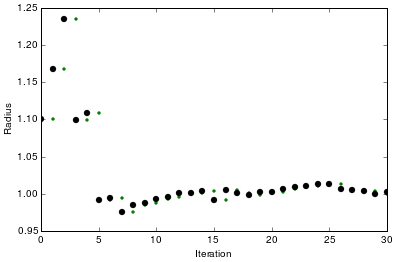

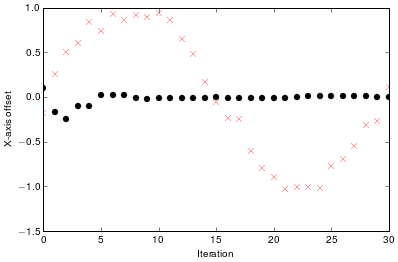

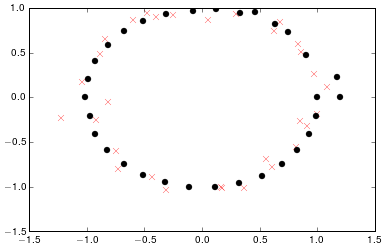

In [9]:

# predicted state vectors for each measurement 
xpredict = np.linspace(0, T, N * state_vec_dim).reshape((state_vec_dim, N))
# filtered state vectors for each measurement
xkal = np.linspace(0, T, N * state_vec_dim).reshape((state_vec_dim, N))
# set initial values
# the construction
for _i, _par in enumerate(true_params):
    xpredict[_i, 0] = _par + 0.1
    xkal[_i, 0] = _par + 0.1
# initial variance on prediction
p = np.identity(state_vec_dim)
# measurement error
r = sigma_pos * np.identity(xmeas.shape[0])
# prediction matrix
# global track parameters do not change in this example
A = np.identity(state_vec_dim)
# map state vector to measurements at surface k
H_k = [np.array([[1, 0, 0, 0, np.cos(t)],
                   [0, 1, 0, 0, np.sin(t)],
                   [0, 0, 1, t, 0]] ) for t in _t]
for i in range(1, N):
    H = H_k[i]
    # prediction: recursive formula
    xpredict[:, i] = np.dot(A, xkal[:, i - 1])
    p = np.dot(np.dot(A, p), A.T)
    K = np.dot(np.dot(p, H.T), 
            np.linalg.inv(np.dot(np.dot(H, p), H.T) + r))
    #print(_resid.shape)
    #print(xmeas4[:,i].shape)
    #print(K4.shape)
    #print(( K4 *  _resid).shape)
    #print( xpredict4[:, i].shape) 
    #print((H4 * np.matrix(xpredict[:,i])).shape)
    #_resid = ((np.array([xmeas[:,i]]).T - H * np.matrix(xpredict[:,i])))
    #xkal[:,i] = xpredict[:,i] + K * _resid 
    xkal[:, i] = xpredict[:, i] + np.dot(K, (xmeas[:, i] - np.dot(H, xpredict[:, i])))
    p = np.dot(np.eye(K.shape[0]) - np.dot(K, H), p)
print(xkal)
fig1 = plt.figure()
ax1 = plt.axes()
plt.plot(xpredict[0].T, 'g.',  label = 'Prediction')
plt.plot(xkal[0].T, 'ko', label = 'Kalman')
plt.xlabel('Iteration')
plt.ylabel('Radius')
fig2 = plt.figure()
ax2 = plt.axes()
plt.plot(xmeas[1].T, 'rx', label = 'Measurement')
plt.plot(xkal[1].T, 'ko', label = 'Kalman')
plt.xlabel('Iteration')
plt.ylabel('X-axis offset')
_plot_data = np.array([np.dot(H_k[i], xpredict[:, i]) for i in range(N)])
print(_plot_data.shape)

plt.figure()
ax = plt.axes
plt.plot(xmeas[0].T, xmeas[1].T, 'rx', label='Measurement')
for i in range(N):
    _plot_data = np.dot(H_k[i], xpredict[:, i])
    plt.plot(_plot_data[0], _plot_data[1], 'ko')

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plt.plot(xmeas[0].T, xmeas[1].T, marker='o')
plt.title('noisy measurements of track')
plt.xlabel('x')
plt.ylabel('y')
#fig = plt.figure(figsize=(6,6))
#ax = fig.add_subplot(111, projection='3d')
print(xtrue[0][0].squeeze().shape)
ax.scatter(*xmeas[:,:], marker='o')
for i in range(N):
    _plot_data = np.dot(H_k[i], xpredict[:, i])
    print(_plot_data)
    ax.scatter(*_plot_data, marker='<', color='black')
plt.draw()